# Missing data, no tears

In this noteboook, we show how to deal with missing data. We will generate two synthetic datasets and then randomly `knockout` some of their values to be missing. The first dataset will have its parameters manually specified, while the second dataset will have its parameters randomly generated.

# Manually created example

In this section we manually generate a dataset while manually specifying the parameters. The number of variables that we are generating is 3, and their means are $[10, 20, 30]$ and the covariance matrix between them is as follows.

$
  \left[ {\begin{array}{ccccc}
   1, 0, 0\\
   0, 1, 0\\
   0, 0, 1\\
  \end{array} } \right]
$

The full data is `data`.

In [1]:
%matplotlib inline
import numpy as np

np.random.seed(37)

means = np.array([10.0, 20.0, 30.0], dtype=np.float64)
cov = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]], dtype=np.float64)
data = np.random.multivariate_normal(means, cov, 100)

Now we randomly generate pairs of indices (row and column) for which we will make the corresponding element missing.

In [2]:
def get_null_indices(num_rows, num_cols, num_nulls=50):
    null_indices = []

    indices_pairs = set()
    while len(null_indices) < num_nulls:
        r = np.random.randint(num_rows)
        c = np.random.randint(num_cols)
        key = '{}-{}'.format(r, c)
        if key not in indices_pairs:
            indices_pairs.add(key)
            t = (r, c)
            null_indices.append(t)

    return null_indices

null_indices = get_null_indices(data.shape[0], data.shape[1])

Let's create the missing data `m_data`.

In [3]:
def knockout_data(data, null_indices):
    m_data = np.copy(data)
    for pair in null_indices:
        r = pair[0]
        c = pair[1]
        m_data[r][c] = None
    return m_data

m_data = knockout_data(data, null_indices)

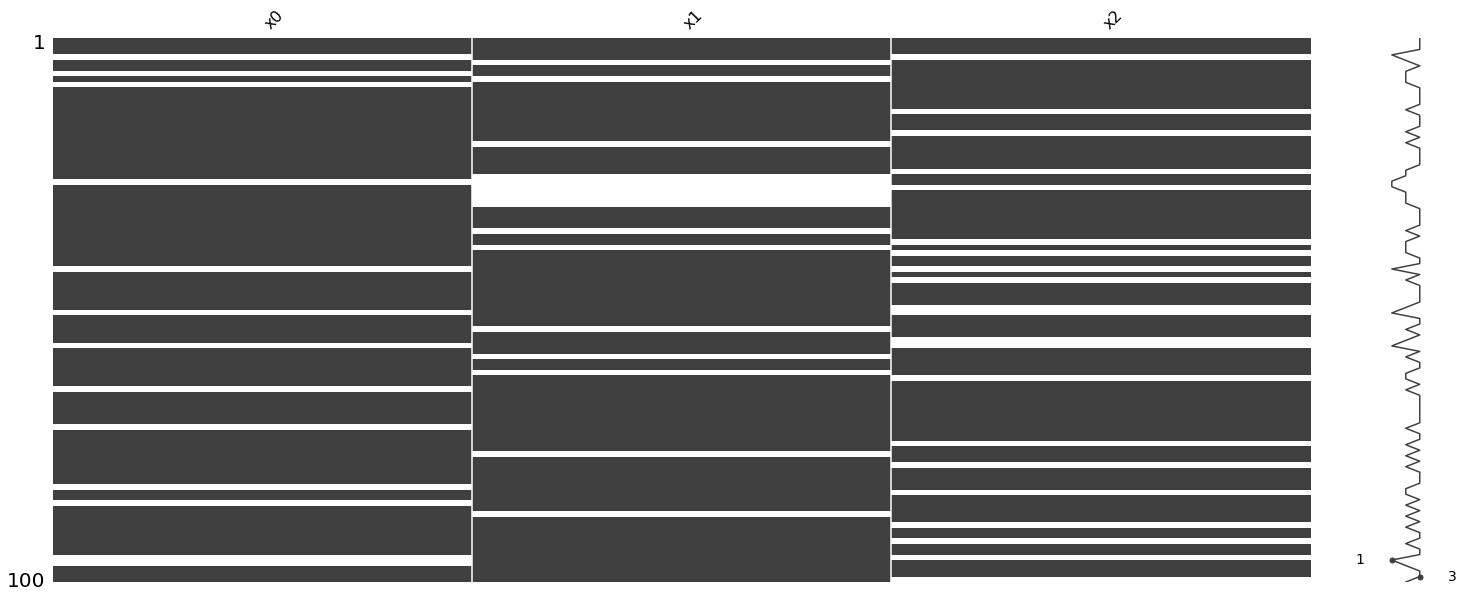

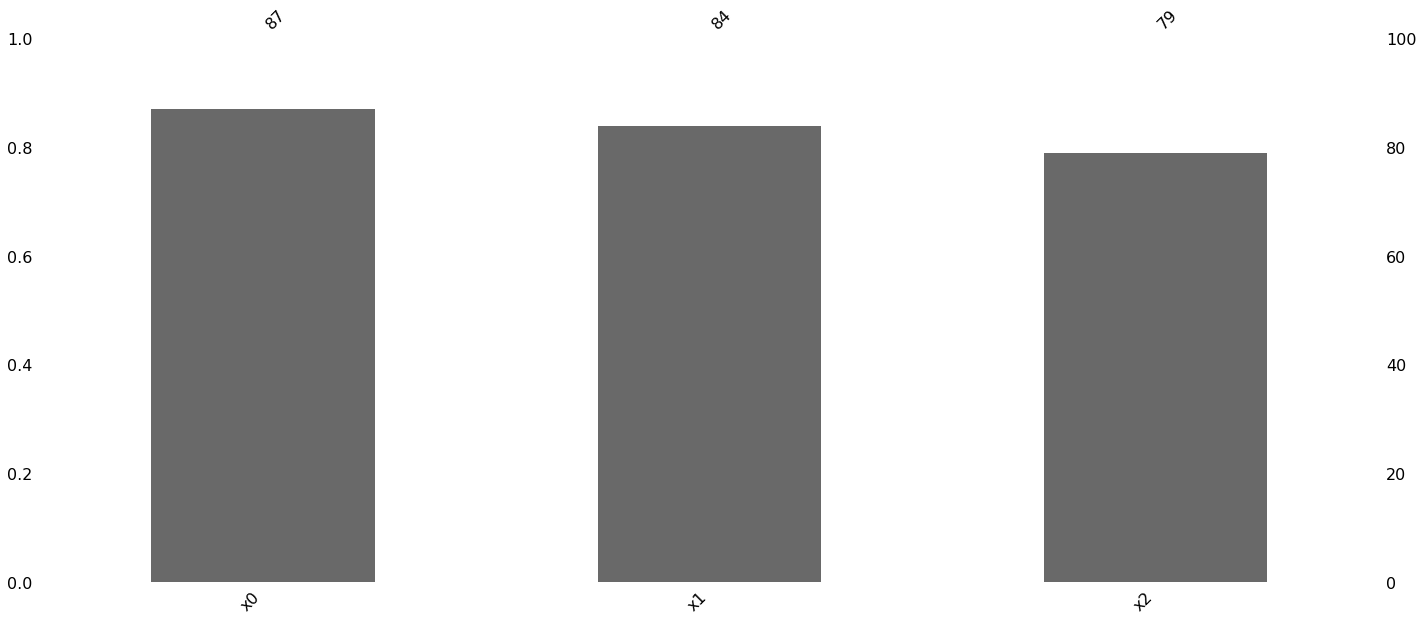

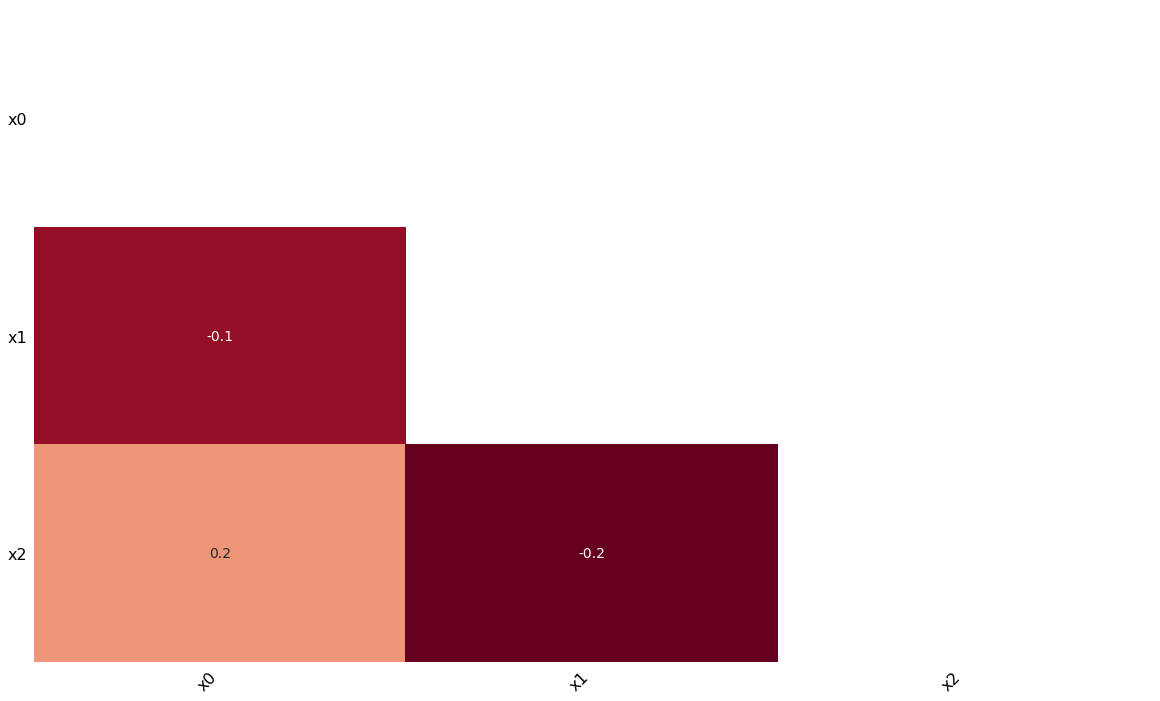

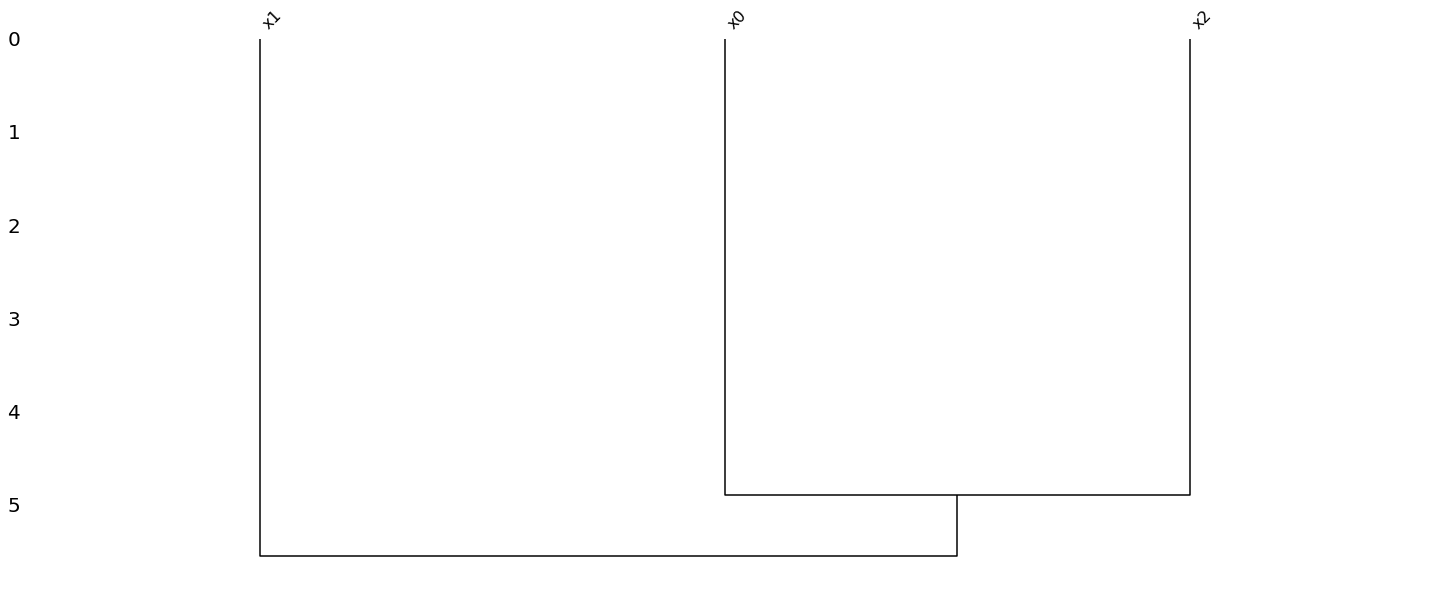

In [4]:
import missingno as msno
import matplotlib
import pandas as pd

data_df = pd.DataFrame(m_data, columns=['x{}'.format(c) for c in range(data.shape[1])])

msno.matrix(data_df)
msno.bar(data_df)
msno.heatmap(data_df)
msno.dendrogram(data_df)

Let's impute the missing data using several different techniques.

In [5]:
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, IterativeImputer, BiScaler

ii_data = IterativeImputer().fit_transform(m_data)
knn_data = KNN(k=7).fit_transform(m_data)
bs_data = BiScaler().fit_transform(m_data)
si_data = SoftImpute().fit_transform(bs_data)

Using TensorFlow backend.


Imputing row 1/100 with 0 missing, elapsed time: 0.003
[BiScaler] Initial log residual value = 10.651151
[BiScaler] Iter 1: log residual = 1.997071, log improvement ratio=8.654080
[BiScaler] Iter 2: log residual = 2.039513, log improvement ratio=-0.042442
[SoftImpute] Max Singular Value of X_init = 11.483246
[SoftImpute] Iter 1: observed MAE=0.020602 rank=3
[SoftImpute] Iter 2: observed MAE=0.020613 rank=3
[SoftImpute] Iter 3: observed MAE=0.020624 rank=3
[SoftImpute] Iter 4: observed MAE=0.020634 rank=3
[SoftImpute] Iter 5: observed MAE=0.020643 rank=3
[SoftImpute] Iter 6: observed MAE=0.020653 rank=3
[SoftImpute] Iter 7: observed MAE=0.020662 rank=3
[SoftImpute] Iter 8: observed MAE=0.020670 rank=3
[SoftImpute] Iter 9: observed MAE=0.020676 rank=3
[SoftImpute] Iter 10: observed MAE=0.020680 rank=3
[SoftImpute] Iter 11: observed MAE=0.020681 rank=3
[SoftImpute] Iter 12: observed MAE=0.020682 rank=3
[SoftImpute] Iter 13: observed MAE=0.020683 rank=3
[SoftImpute] Iter 14: observed MAE=0

Let's observe the performances of the imputation techniques.

In [6]:
def get_mse(f_data, i_data, null_indices):
    t = []
    for pair in null_indices:
        r, c = pair[0], pair[1]
        v1 = f_data[r][c]
        v2 = i_data[r][c]
        diff = np.power(v1 - v2, 2.0)
        # print('{:.10f}, {:.10f}, {:.10f}'.format(v1, v2, diff))
        t.append(diff)
    t = np.array(t)
    m = np.mean(t)
    return m

def get_mean_mse(f_data, i_data):
    m1 = np.mean(f_data, axis=0)
    m2 = np.mean(i_data, axis=0)
    num_means = len(m1)
    t = []
    for i in range(num_means):
        v1 = m1[i]
        v2 = m2[i]
        diff = np.power(v1 - v2, 2.0)
        t.append(diff)
    t = np.array(t)
    m = np.mean(t)
    return m

def get_cov_mse(f_data, i_data):
    cov1 = np.cov(f_data.T)
    cov2 = np.cov(i_data.T)
    num_rows, num_cols = cov1.shape[0], cov1.shape[1]
    t = []
    for r in range(num_rows):
        for c in range(num_cols):
            v1 = cov1[r][c]
            v2 = cov2[r][c]
            diff = np.power(v1 - v2, 2.0)
            t.append(diff)
    t = np.array(t)
    m = np.mean(t)
    return m

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
s_data = scaler.fit_transform(data)

print('{:.5f} | iterative mse'.format(get_mse(data, ii_data, null_indices)))
print('{:.5f} | knn mse'.format(get_mse(data, knn_data, null_indices)))
print('{:.5f} | soft impute mse'.format(get_mse(s_data, si_data, null_indices)))
print('>')
print('{:.5f} | iterative mean mse'.format(get_mean_mse(data, ii_data)))
print('{:.5f} | knn mean mse'.format(get_mean_mse(data, knn_data)))
print('{:.5f} | soft impute mean mse'.format(get_mean_mse(s_data, si_data)))
print('>')
print('{:.5f} | iterative covariance mse'.format(get_cov_mse(data, ii_data)))
print('{:.5f} | knn covariance mse'.format(get_cov_mse(data, knn_data)))
print('{:.5f} | soft impute covariance mse'.format(get_cov_mse(s_data, si_data)))

0.87309 | iterative mse
1.33841 | knn mse
0.98859 | soft impute mse
>
0.00276 | iterative mean mse
0.00369 | knn mean mse
0.00026 | soft impute mean mse
>
0.00744 | iterative covariance mse
0.00527 | knn covariance mse
0.11567 | soft impute covariance mse


# Randomly generated synthetic example

Now we generate a dataset of 10 random variables with the parameters (means and covariance matrix) generated randomly (as opposed to manually specified as before). We go through the whole process of 

* parameter generation,
* data generation,
* missing data creation, and
* imputation.

We then visualize the missingness, followed by computing the performances of the imputation techniques.

In [8]:
num_vars = 10

means = np.array([np.random.randint(20, 100) for i in range(num_vars)], dtype=np.float64)
cov = []
for i in range(num_vars):
    for j in range(num_vars):
        if i == j:
            cov.append(1.0)
        else:
            cov.append(np.random.randint(1, 10))

cov = np.array(cov, dtype=np.float64).reshape((num_vars, num_vars))
data = np.random.multivariate_normal(means, cov, 500)

null_indices = get_null_indices(data.shape[0], data.shape[1], num_nulls=1000)
m_data = knockout_data(data, null_indices)

ii_data = IterativeImputer().fit_transform(m_data)
knn_data = KNN(k=7).fit_transform(m_data)
bs_data = BiScaler().fit_transform(m_data)
si_data = SoftImpute().fit_transform(bs_data)

scaler = StandardScaler()
s_data = scaler.fit_transform(data)

Imputing row 1/500 with 2 missing, elapsed time: 0.047


/anaconda3/envs/ds-missing/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  del sys.path[0]


Imputing row 101/500 with 1 missing, elapsed time: 0.053
Imputing row 201/500 with 4 missing, elapsed time: 0.059
Imputing row 301/500 with 4 missing, elapsed time: 0.066
Imputing row 401/500 with 3 missing, elapsed time: 0.071
[BiScaler] Initial log residual value = 13.840885
[BiScaler] Iter 1: log residual = -0.313077, log improvement ratio=14.153961
[BiScaler] Iter 2: log residual = -2.247585, log improvement ratio=1.934508
[BiScaler] Iter 3: log residual = -4.135190, log improvement ratio=1.887605
[BiScaler] Iter 4: log residual = -5.979987, log improvement ratio=1.844797
[BiScaler] Iter 5: log residual = -7.799754, log improvement ratio=1.819767
[BiScaler] Iter 6: log residual = -9.602809, log improvement ratio=1.803054
[BiScaler] Iter 7: log residual = -11.394249, log improvement ratio=1.791441
[BiScaler] Iter 8: log residual = -13.177500, log improvement ratio=1.783251
[BiScaler] Iter 9: log residual = -14.954922, log improvement ratio=1.777422
[BiScaler] Iter 10: log residual =

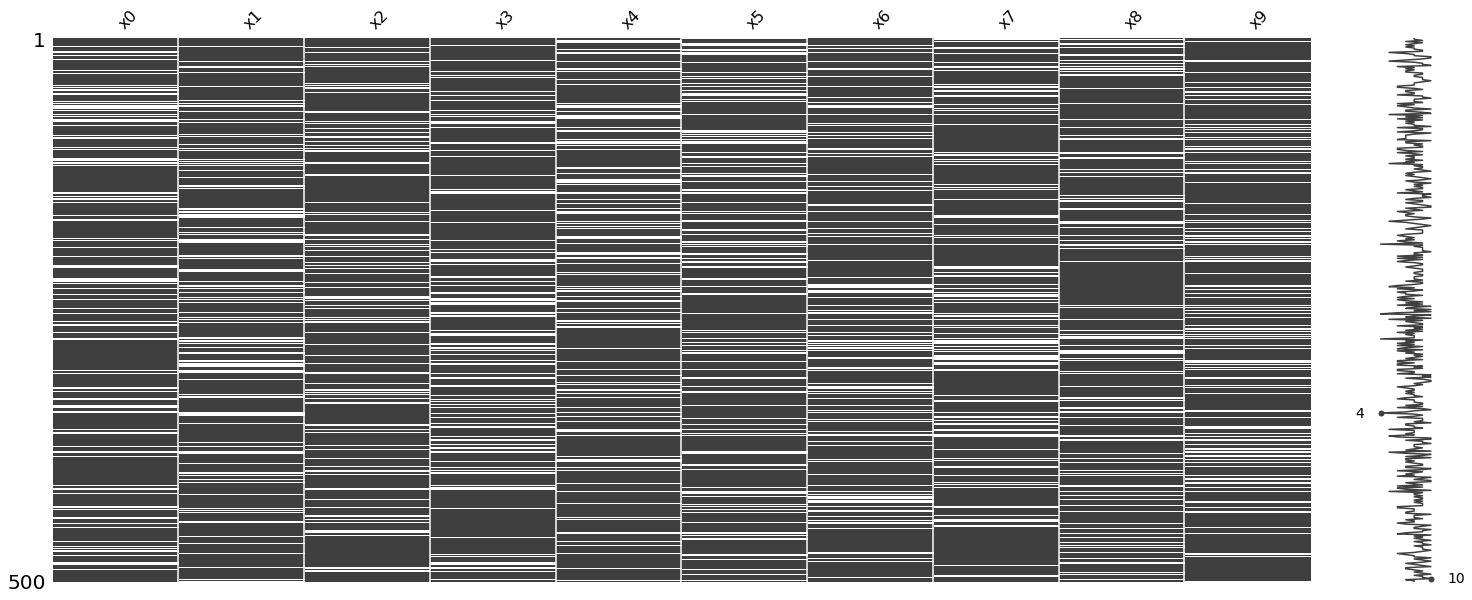

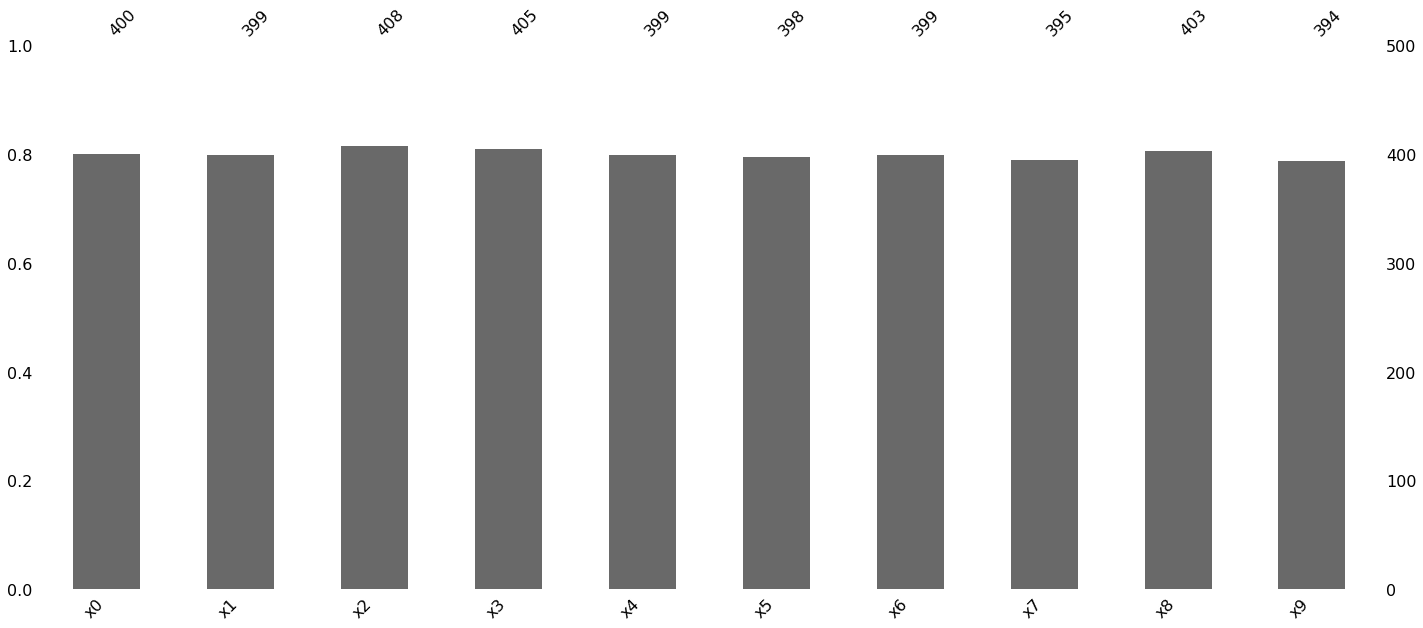

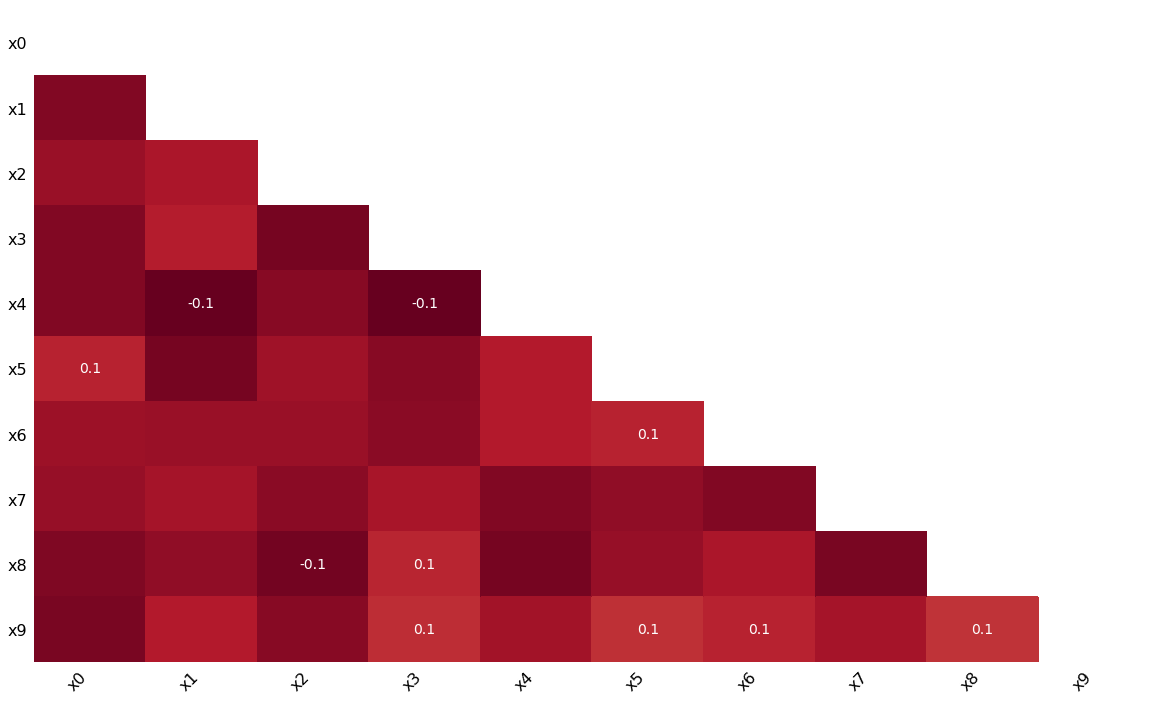

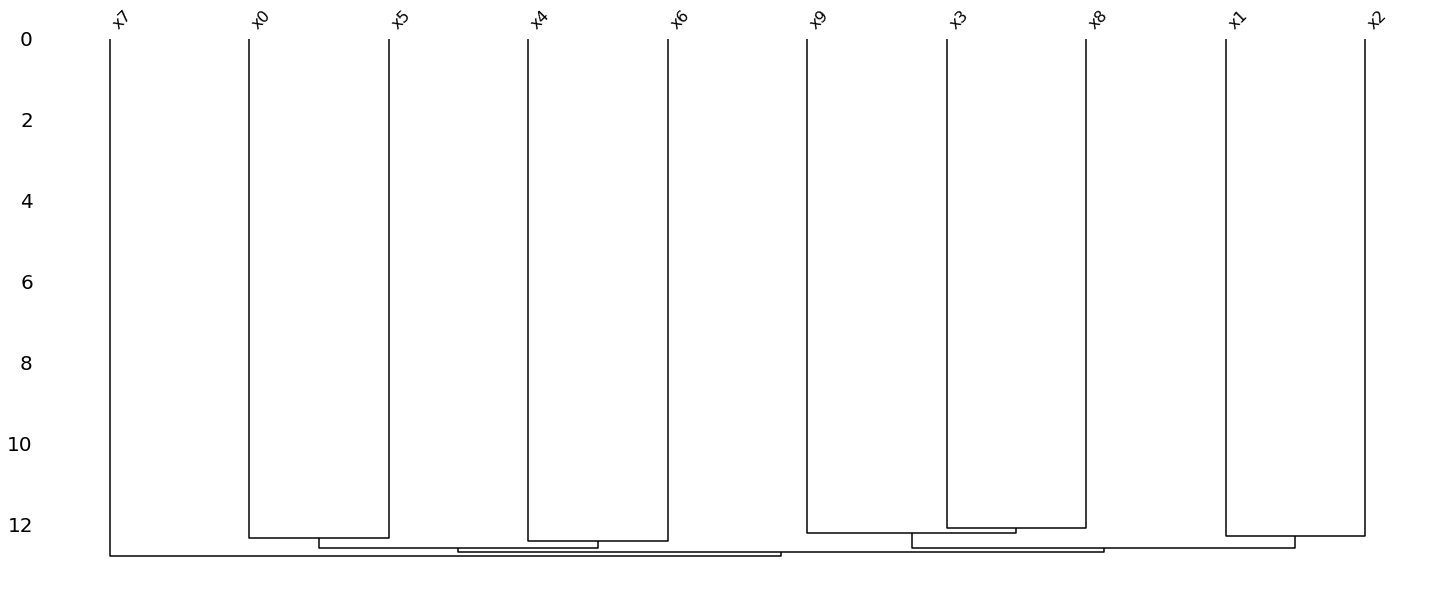

In [9]:
data_df = pd.DataFrame(m_data, columns=['x{}'.format(c) for c in range(data.shape[1])])
msno.matrix(data_df)
msno.bar(data_df)
msno.heatmap(data_df)
msno.dendrogram(data_df)

As can be seen below, iterative imputation seems to do the best by perserving the mean of each variable and also the covariance. 

In [10]:
print('{:.5f} | iterative mse'.format(get_mse(data, ii_data, null_indices)))
print('{:.5f} | knn mse'.format(get_mse(data, knn_data, null_indices)))
print('{:.5f} | soft impute mse'.format(get_mse(s_data, si_data, null_indices)))
print('>')
print('{:.5f} | iterative mean mse'.format(get_mean_mse(data, ii_data)))
print('{:.5f} | knn mean mse'.format(get_mean_mse(data, knn_data)))
print('{:.5f} | soft impute mean mse'.format(get_mean_mse(s_data, si_data)))
print('>')
print('{:.5f} | iterative covariance mse'.format(get_cov_mse(data, ii_data)))
print('{:.5f} | knn covariance mse'.format(get_cov_mse(data, knn_data)))
print('{:.5f} | soft impute covariance mse'.format(get_cov_mse(s_data, si_data)))

6.57553 | iterative mse
8.68604 | knn mse
0.90964 | soft impute mse
>
0.00183 | iterative mean mse
0.00731 | knn mean mse
0.00001 | soft impute mean mse
>
0.13863 | iterative covariance mse
0.62392 | knn covariance mse
0.18493 | soft impute covariance mse


# References

* [Missing Data Conundrum: Exploration and Imputation Techniques](https://medium.com/ibm-data-science-experience/missing-data-conundrum-exploration-and-imputation-techniques-9f40abe0fd87)
* [Failed to load the native TensorFlow runtime](https://github.com/tensorflow/tensorflow/issues/18503)


# Take a Look!

Take a look at [Dr. Abraham Wald](https://en.wikipedia.org/wiki/Abraham_Wald), the inventor of the once classified technique called [Sequential Probability Ratio Test](https://en.wikipedia.org/wiki/Sequential_probability_ratio_test).